# Modelos baseados em Recurrent Neural Network (RNN)

## Sumário:

* [1. Preparação](#1-preparacao)
* [2. Estatística descritiva](#2.-estatistica-descritiva)
* [3. LSTM](#3.-LSTM)
    * [Arquitetura da rede](#-arquitetura-da-rede)
    * [Configurações](#-configuracoes)
    * [Cenários](#-cenarios)

<hr>

## 1. Preparacao

In [1]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings 
import torch

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
df = pd.read_csv("us_change.csv")
print("Tamanho: ", df.shape)
df.head(11)

Tamanho:  (198, 6)


,Quarter,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
1,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
2,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
3,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
4,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
5,1971 Q2,0.914877,1.445909,0.901570,5.874764,-0.1
6,1971 Q3,0.794110,0.521149,0.308031,-0.406235,0.1
7,1971 Q4,1.645633,1.159176,2.291362,-1.486259,0.0
8,1972 Q1,1.311190,0.456857,4.154295,-4.291972,-0.2
9,1972 Q2,1.885778,1.033389,1.888673,-4.692196,-0.1


## 2. Estatistica descritiva

In [ ]:
def descriptive_statistics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula estatísticas descritivas para cada coluna no dataframe.

    Parâmetros:
    df (pd.DataFrame): O dataframe a ser analisado.

    Retorna:
    pd.DataFrame: Um dataframe contendo o mínimo, média, mediana, modo,
    máximo, variância e intervalo, para cada coluna.
    """

    desc_stats = pd.DataFrame({
        "Mínimo": df.min(),
        "Média": df.mean(),
        "Mediana": df.median(),
        "Moda": df.mode().iloc[0],
        "Máximo": df.max(),
        "Variância": df.var(),
        "Intervalo": df.max() - df.min(),
        "Porcentagem nulos": df.isnull().mean() * 100
    })

    return desc_stats

df_desc = descriptive_statistics(df[df.columns[1:]])
df_desc

,Mínimo,Média,Mediana,Moda,Máximo,Variância,Intervalo,Porcentagem nulos
Consumption,-2.277836,0.742482,0.776656,-2.277836,2.319558,0.406869,4.597393,0.0
Income,-4.084420,0.728169,0.760346,-4.084420,4.521869,0.810707,8.606288,0.0
Production,-6.836039,0.507083,0.666085,-6.836039,4.154295,2.314504,10.990334,0.0
Savings,-56.471910,1.392258,1.349359,-56.471910,41.607730,143.192915,98.079639,0.0
Unemployment,-0.900000,0.001010,-0.100000,0.000000,1.400000,0.134923,2.300000,0.0


## 3. LSTM

### Arquitetura da rede:

In [ ]:
class LSTMModel(nn.Module):
    """
    Modelo LSTM com uma camada de dropout e uma camada totalmente conectada.

    Parâmetros:
    input_size (int): Tamanho da entrada.
    hidden_layer_size (int): Tamanho da camada oculta.
    output_size (int): Tamanho da saída.

    Atributos:
    hidden_layer_size (int): Tamanho da camada oculta.
    lstm (nn.LSTM): Camada LSTM.
    dropout (nn.Dropout): Camada de dropout com taxa de 20%.
    fc (nn.Linear): Camada totalmente conectada que mapeia a saída da LSTM para a saída desejada.
    """

    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)              # Dropout com taxa de 20%
        self.fc = nn.Linear(hidden_layer_size, output_size)


    def forward(self, x):
        """
        Propaga a entrada através da rede.

        Parâmetros:
        x (Tensor): Tensor de entrada.

        Retorna:
        Tensor: Predições da rede.
        """
        
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)           # Aplica Dropout nas saídas do LSTM
        predictions = self.fc(lstm_out[:, -1, :])   # Último estado

        return predictions

### Configuracoes

Funções de suporte relacionadas a criação de ceánrios:

In [28]:
def decompose_series(df, period=4, use_residual_only=False):
    """
    Decompoe uma série temporal em seus componentes de tendência, sazonalidade e resíduo.

    Parâmetros:
    df (DataFrame): DataFrame contendo a série temporal com uma coluna 'Consumption'.
    period (int): O período da sazonalidade. Default é 4.
    use_residual_only (bool): Se True, substitui a coluna 'Consumption' pelos resíduos. Default é False.

    Retorna:
    DataFrame: DataFrame com as colunas 'Trend', 'Seasonal' e 'Residual' adicionadas, ou com 'Consumption' substituído por resíduos se use_residual_only for True.
    """
    
    result = seasonal_decompose(df["Consumption"], model="additive", period=period)
    if use_residual_only:
        df["Consumption"] = result.resid
    else:
        df["Trend"] = result.trend
        df["Seasonal"] = result.seasonal
        df["Residual"] = result.resid

    # Preenchendo valores NaN
    df.fillna(method="bfill", inplace=True)  # Preencher NaN com valores anteriores
    df.fillna(method="ffill", inplace=True)  # Preencher NaN com valores subsequentes

    return df


def normalize_data(df):
    """
    Normaliza a variável 'Consumption' e outras variáveis de entrada no DataFrame.

    Parâmetros:
    df (DataFrame): DataFrame contendo as colunas 'Consumption', 'Income', 'Production', 'Savings' e 'Unemployment'.

    Retorna:
    DataFrame: DataFrame com a variável 'Consumption' normalizada.
    MinMaxScaler: Objeto scaler usado para normalizar a variável 'Consumption'.
    MinMaxScaler: Objeto scaler usado para normalizar as variáveis de entrada.
    """
    
    # Normalizando apenas a variável 'Consumption'
    scaler_consumption = MinMaxScaler(feature_range=(0, 1))
    df["Consumption"] = scaler_consumption.fit_transform(df[["Consumption"]])

    # Normalizando as variáveis de entrada
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler_features.fit_transform(df[["Income", "Production", "Savings", "Unemployment"]])
    
    return df, scaler_consumption, scaler_features


def create_dataset(data, time_step=1):
    """
    Cria datasets de entrada (X) e saída (y) a partir de uma série temporal.

    Parâmetros:
    data (array): Array contendo os dados normalizados.
    time_step (int): O número de passos de tempo a serem usados como entrada.

    Retorna:
    array: Array de entradas (X) para o modelo.
    array: Array de saídas (y) para o modelo.
    """

    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, :])        # Todas as variáveis como entrada
        y.append(data[i+time_step, 0])          # Apenas 'Consumption' como variável alvo

    return np.array(X), np.array(y)

Funções de plotagem:

In [34]:
def plot_training_loss(train_losses, scenario):
    """
    Gera um gráfico mostrando a evolução da perda de treinamento ao longo das épocas.

    Parâmetros:
    train_losses (list): Lista contendo os valores da perda de treinamento para cada época.
    scenario (str): Descrição do cenário (ex.: parâmetros usados no modelo) a ser incluída no título do gráfico.

    Retorna:
    None: Apenas exibe o gráfico gerado.
    """
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Loss de treinamento")
    plt.title(f"Evolução da perda de treinamento ({scenario})")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()


def plot_all_intervals(df, X_train, y_train, y_pred_train, X_test, y_test, y_pred_test, time_step, scenario=""):
    """
    Função para plotar todos os intervalos de dados, incluindo:
    - Dados de Treinamento
    - Dados de Teste
    - Previsões de Treinamento
    - Previsões de Teste

    Parâmetros:
    df (DataFrame): DataFrame com os dados originais, incluindo a coluna 'Quarter'.
    X_train (Tensor): Dados de entrada de treino.
    y_train (Tensor): Valores reais de treino.
    y_pred_train (Tensor): Previsões do modelo para os dados de treino.
    X_test (Tensor): Dados de entrada de teste.
    y_test (Tensor): Valores reais de teste.
    y_pred_test (Tensor ou array): Previsões do modelo para os dados de teste.
    time_step (int): Tamanho da janela de tempo usada para criação dos dados.
    scenario (str): Descrição do cenário a ser usada no título do gráfico.

    Retorna:
    None: Apenas exibe o gráfico gerado.
    """

    # Converte os dados para numpy para plotagem
    y_train_actual = y_train.flatten()
    y_test_actual = y_test.flatten()
    y_pred_test = y_pred_test.flatten()

    # Define o eixo x com a coluna 'Quarter' do DataFrame
    x_values = df['Quarter'].values

    # Plota o gráfico
    plt.figure(figsize=(12, 6))

    # Plota os dados de treino (com espaço vazio para os primeiros time_steps)
    plt.plot(x_values[:len(y_train_actual) + time_step], df['Consumption'].values[:len(y_train_actual) + time_step], label='Dados de Treinamento', color='blue')

    # Plota as previsões para treino
    plt.plot(x_values[time_step:len(y_train_actual) + time_step], y_pred_train, label='Previsões de Treinamento', color='purple', linestyle='--')

    # Plota os dados de teste
    plt.plot(x_values[len(y_train_actual) + time_step:len(y_train_actual) + time_step + len(y_test_actual)],
             y_test_actual, label='Dados de Teste', color='green')

    # Plota as previsões para teste
    plt.plot(x_values[len(y_train_actual) + time_step:len(y_train_actual) + time_step + len(y_test_actual)],
             y_pred_test, label='Previsões de Teste', color='red', linestyle='--')


    # Adicion título e labels
    plt.title(f"Série Temporal de Consumo e Previsões ({scenario})")
    plt.xlabel('Trimestre')
    plt.ylabel('% mudança')

    # Ajusta os ticks no eixo X para limitar o número de rótulos
    step = 10                       # Intervalo para exibir os rótulos (exemplo: 1 rótulo a cada 10 trimestres)
    plt.xticks(ticks=np.arange(0, len(x_values), step), labels=x_values[::step], rotation=45)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()

    # Exibindo o gráfico
    plt.show()

Treinamento de um cenário:

In [31]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model, criterion, optimizer, 
                             epochs=1000, print_intervals=10, normalize=False, scaler_consumption=None, 
                             df=None, time_step=4, scenario=""):
    """
    Treina e avalia um modelo de rede neural, com suporte para desnormalização de previsões.

    Parâmetros:
    X_train (numpy.ndarray): Dados de entrada para treinamento.
    y_train (numpy.ndarray): Dados de saída para treinamento.
    X_test (numpy.ndarray): Dados de entrada para teste.
    y_test (numpy.ndarray): Dados de saída para teste.
    model (torch.nn.Module): O modelo de rede neural a ser treinado e avaliado.
    criterion (torch.nn.modules.loss._Loss): Função de perda a ser utilizada.
    optimizer (torch.optim.Optimizer): Otimizador a ser utilizado.
    epochs (int): Número de épocas para treinamento. Default é 1000.
    print_intervals (int): Intervalo de épocas para impressão do log. Default é 10.
    normalize (bool): Indica se os dados foram normalizados. Default é False.
    scaler_consumption (MinMaxScaler): Scaler usado para normalizar a variável 'Consumption'. Necessário se `normalize=True`.
    df (DataFrame): DataFrame original para visualização. Default é None.
    time_step (int): Tamanho da janela temporal. Default é 4.
    scenario (str): Descrição do cenário para plotagem. Default é "".

    Retorna:
    tuple: Métricas de avaliação (MSE, R², MAPE).
    """

    # Converte para tensor
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    train_losses = []

    # Treinamento
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        y_pred = model(X_train)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        # Salvando a perda para plotagem
        train_losses.append(loss.item())

        # Logs em intervalos de tamanho n
        if epoch % print_intervals == 0 or epoch == epochs:
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

    # Avaliação final
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train)
        y_pred_test = model(X_test)

    # Desnormalizando previsões e valores reais, se necessário
    if normalize and scaler_consumption is not None:
        y_pred_test_descaled = scaler_consumption.inverse_transform(y_pred_test.numpy().reshape(-1, 1))
        y_test_descaled = scaler_consumption.inverse_transform(y_test.numpy().reshape(-1, 1))
    else:
        y_pred_test_descaled = y_pred_test.numpy()
        y_test_descaled = y_test.numpy()

    # Calculando métricas
    mse = mean_squared_error(y_test_descaled, y_pred_test_descaled)
    r2 = r2_score(y_test_descaled, y_pred_test_descaled)
    mape = mean_absolute_percentage_error(y_test_descaled, y_pred_test_descaled)

    # Plota a perda de treinamento
    plot_training_loss(train_losses, scenario)
    
    # Plota os intervalos de dados e previsões
    if df is not None:
        plot_all_intervals(df, X_train, y_train, y_pred_train, X_test, y_test_descaled, y_pred_test_descaled, time_step, scenario)

    return mse, r2, mape

### Cenarios

Loop principal para iterar entre as possibilidades e criar os cenários de treinamento do LSTM:

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 4 - Resíduo: Sim - Normalização: Sim
Epoch [100/1000], Loss: 0.0295
Epoch [200/1000], Loss: 0.0222
Epoch [300/1000], Loss: 0.0211
Epoch [400/1000], Loss: 0.0162
Epoch [500/1000], Loss: 0.0139
Epoch [600/1000], Loss: 0.0107
Epoch [700/1000], Loss: 0.0079
Epoch [800/1000], Loss: 0.0052
Epoch [900/1000], Loss: 0.0047
Epoch [1000/1000], Loss: 0.0042


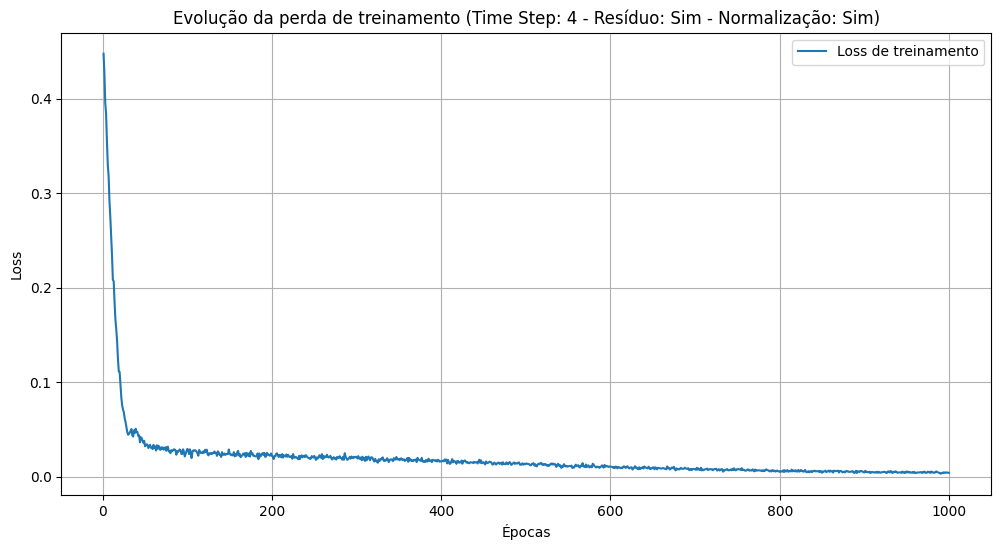

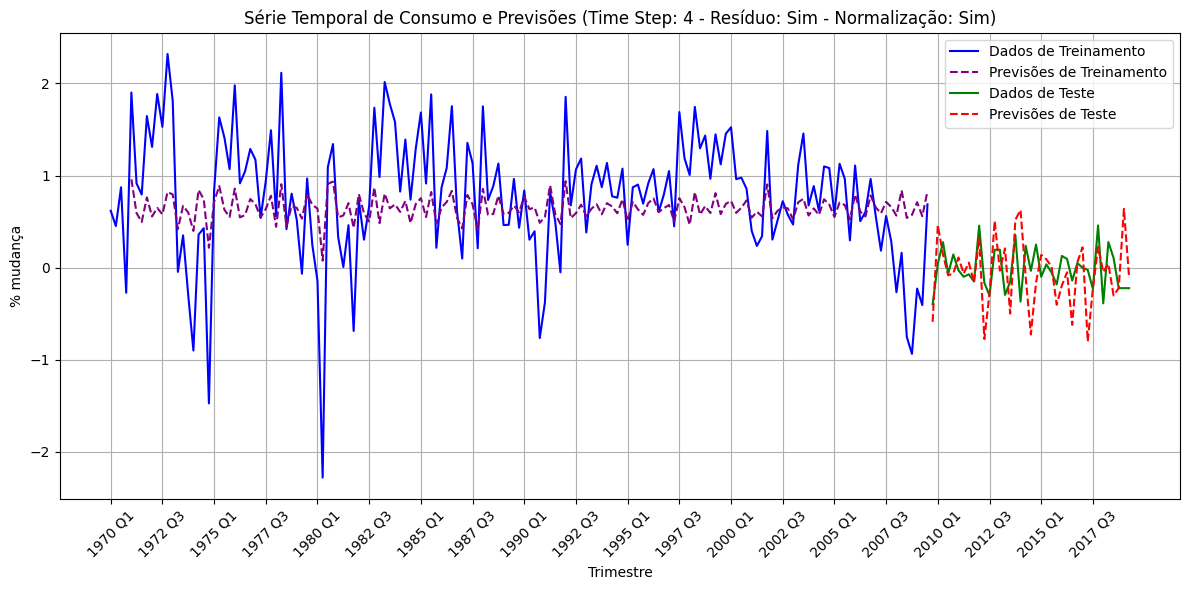

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 4 - Resíduo: Sim - Normalização: Não
Epoch [100/1000], Loss: 0.1353
Epoch [200/1000], Loss: 0.0482
Epoch [300/1000], Loss: 0.0239
Epoch [400/1000], Loss: 0.0159
Epoch [500/1000], Loss: 0.0119
Epoch [600/1000], Loss: 0.0123
Epoch [700/1000], Loss: 0.0083
Epoch [800/1000], Loss: 0.0104
Epoch [900/1000], Loss: 0.0073
Epoch [1000/1000], Loss: 0.0065


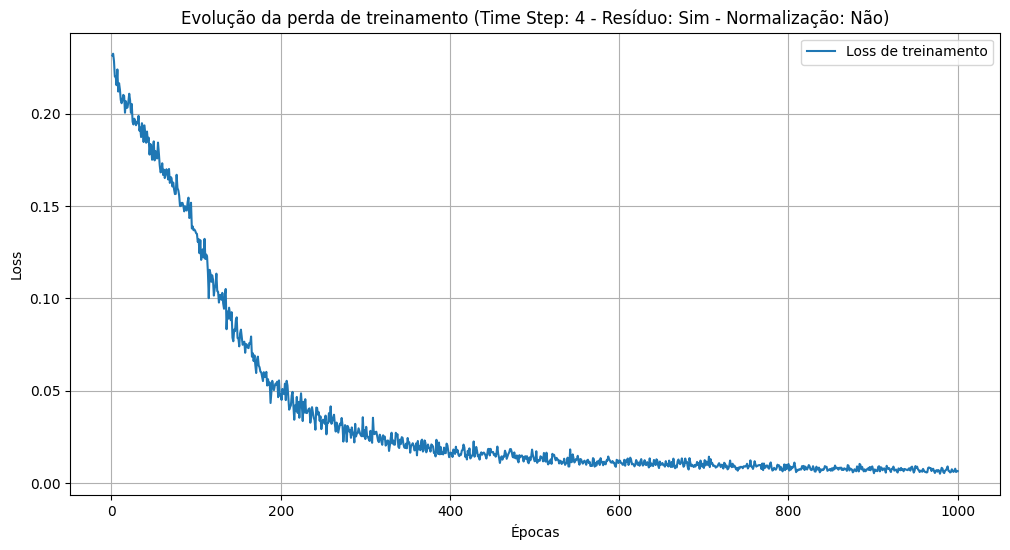

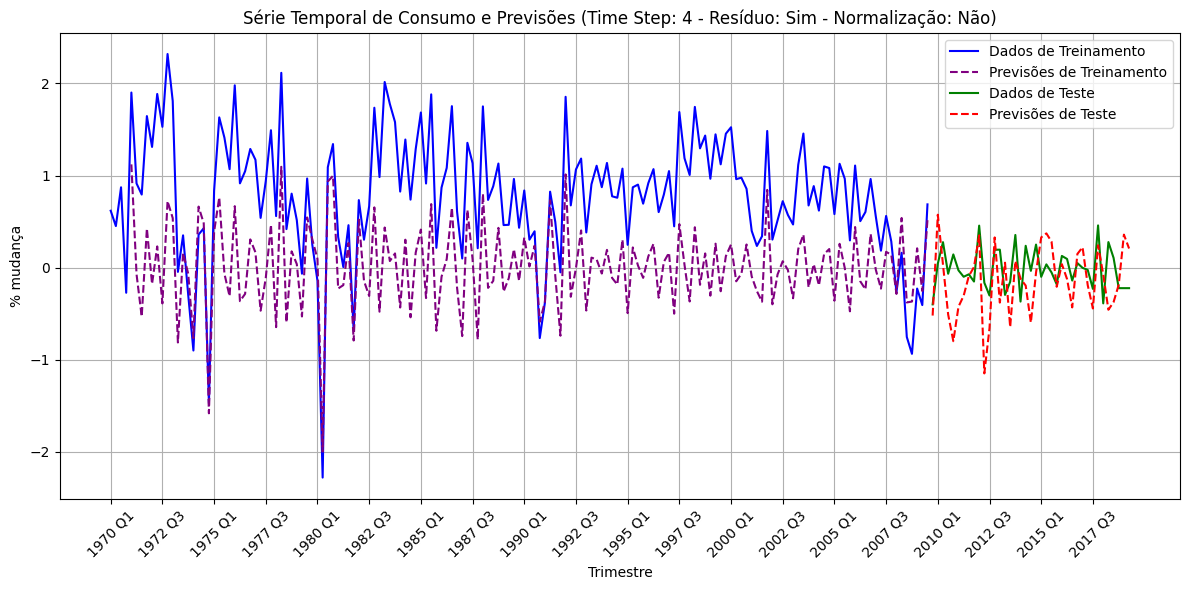

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 4 - Resíduo: Não - Normalização: Sim
Epoch [100/1000], Loss: 0.0223
Epoch [200/1000], Loss: 0.0230
Epoch [300/1000], Loss: 0.0183
Epoch [400/1000], Loss: 0.0169
Epoch [500/1000], Loss: 0.0149
Epoch [600/1000], Loss: 0.0125
Epoch [700/1000], Loss: 0.0099
Epoch [800/1000], Loss: 0.0083
Epoch [900/1000], Loss: 0.0067
Epoch [1000/1000], Loss: 0.0078


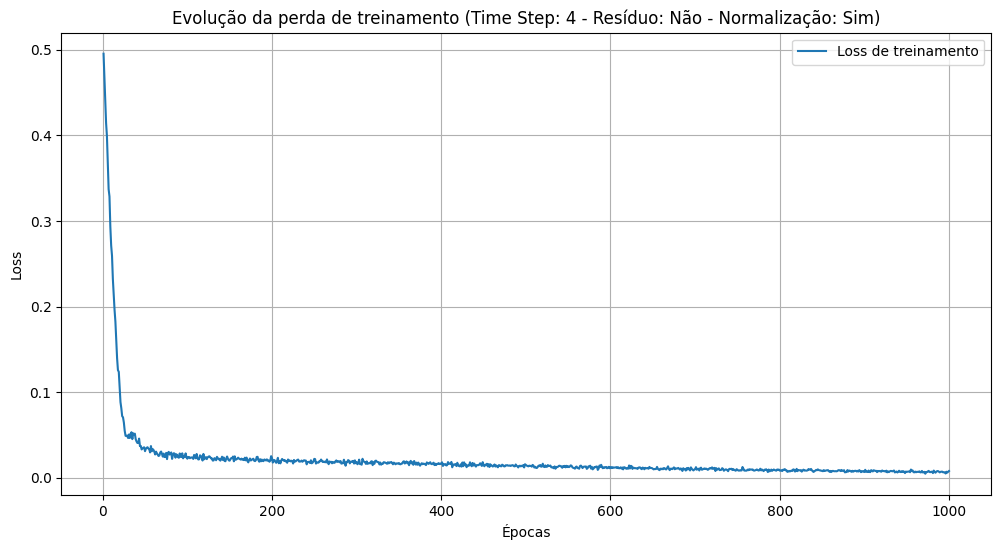

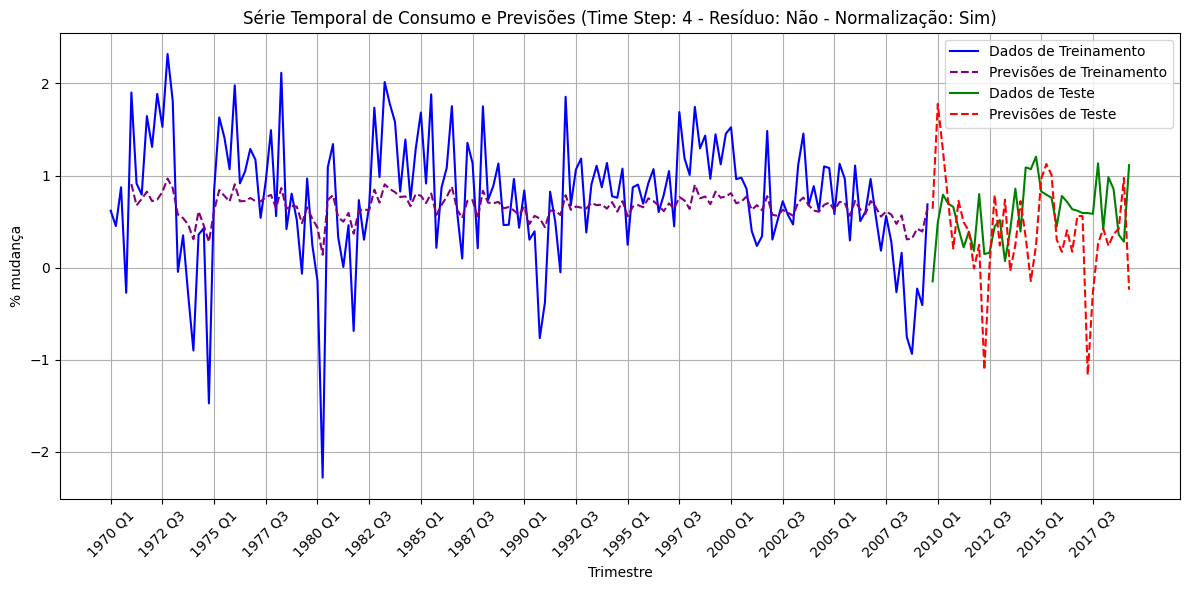

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 4 - Resíduo: Não - Normalização: Não
Epoch [100/1000], Loss: 0.3561
Epoch [200/1000], Loss: 0.2158
Epoch [300/1000], Loss: 0.0873
Epoch [400/1000], Loss: 0.0594
Epoch [500/1000], Loss: 0.0356
Epoch [600/1000], Loss: 0.0357
Epoch [700/1000], Loss: 0.0239
Epoch [800/1000], Loss: 0.0185
Epoch [900/1000], Loss: 0.0225
Epoch [1000/1000], Loss: 0.0148


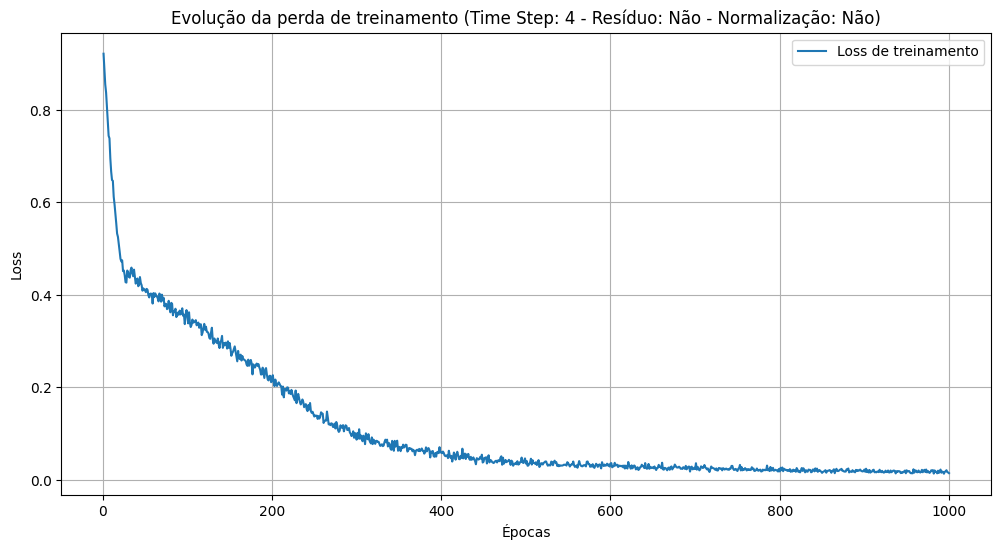

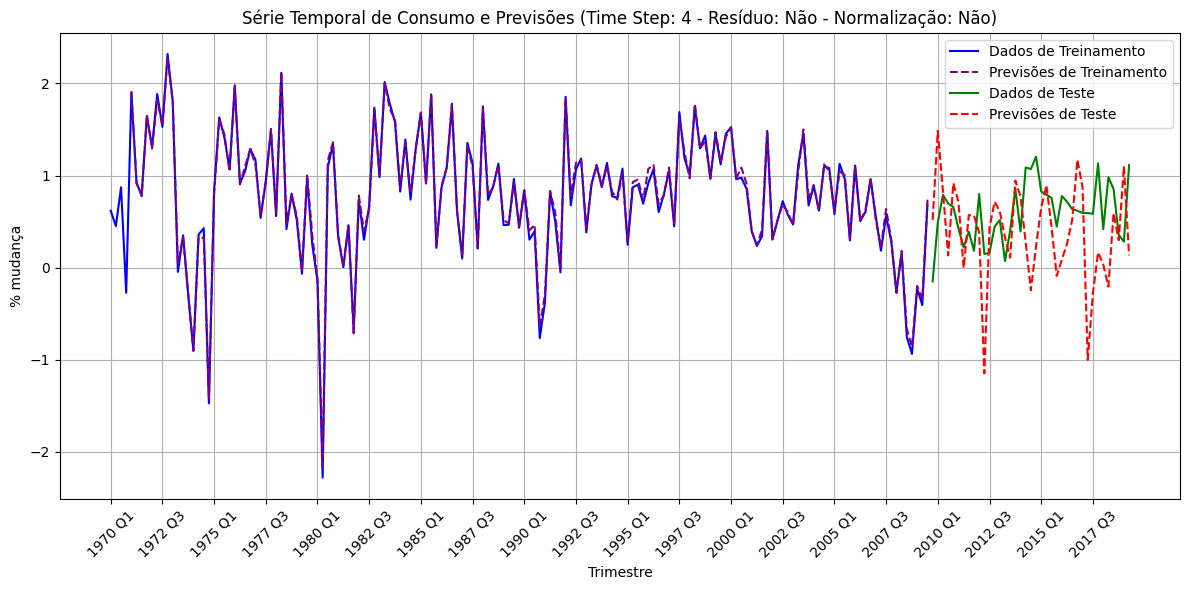

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 8 - Resíduo: Sim - Normalização: Sim
Epoch [100/1000], Loss: 0.0275
Epoch [200/1000], Loss: 0.0241
Epoch [300/1000], Loss: 0.0185
Epoch [400/1000], Loss: 0.0163
Epoch [500/1000], Loss: 0.0123
Epoch [600/1000], Loss: 0.0111
Epoch [700/1000], Loss: 0.0079
Epoch [800/1000], Loss: 0.0066
Epoch [900/1000], Loss: 0.0061
Epoch [1000/1000], Loss: 0.0053


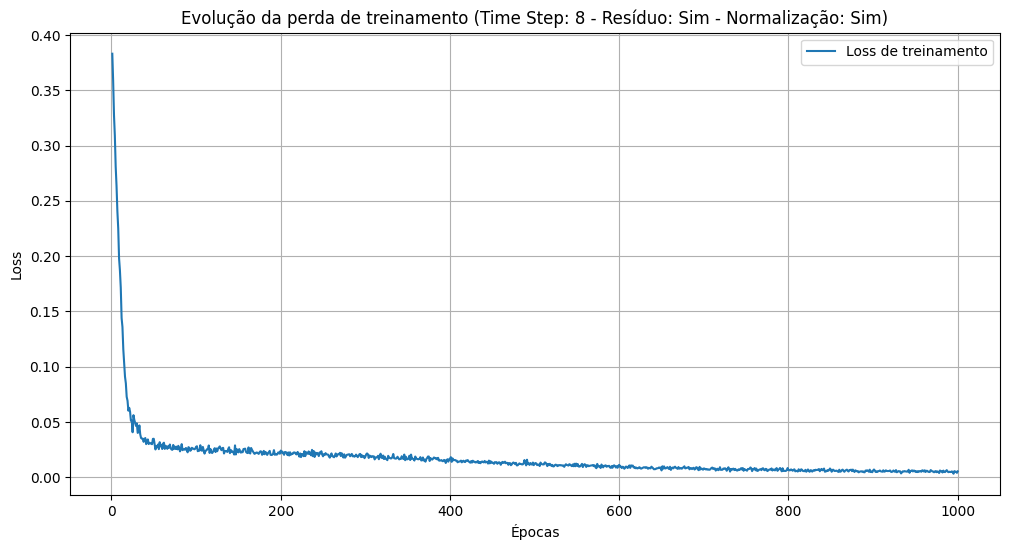

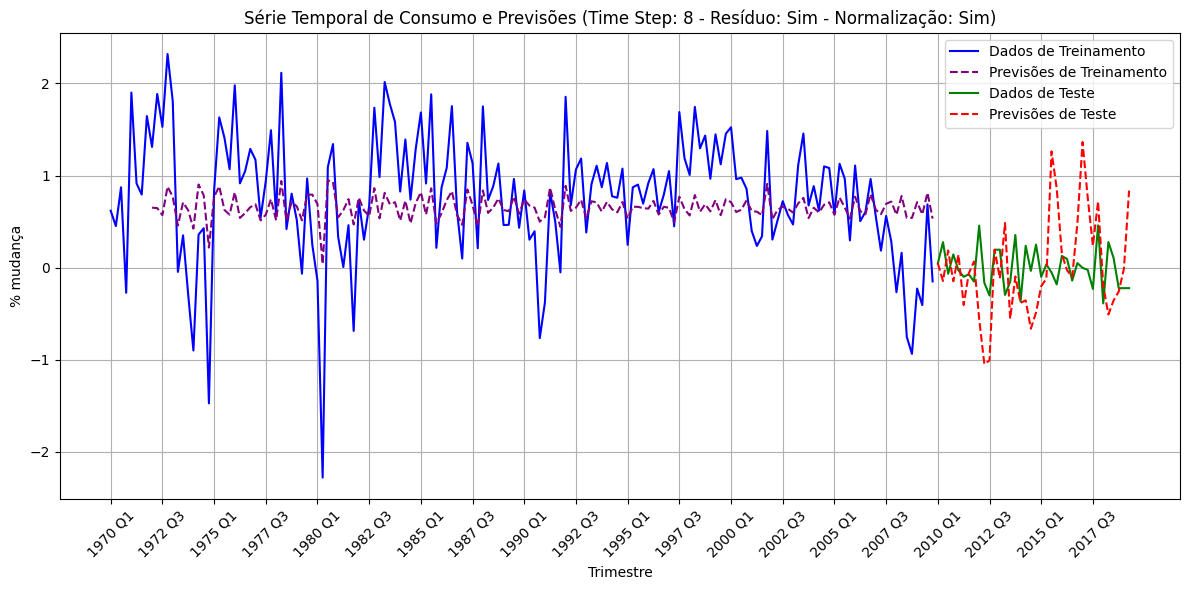

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 8 - Resíduo: Sim - Normalização: Não
Epoch [100/1000], Loss: 0.1446
Epoch [200/1000], Loss: 0.0460
Epoch [300/1000], Loss: 0.0272
Epoch [400/1000], Loss: 0.0132
Epoch [500/1000], Loss: 0.0099
Epoch [600/1000], Loss: 0.0091
Epoch [700/1000], Loss: 0.0098
Epoch [800/1000], Loss: 0.0088
Epoch [900/1000], Loss: 0.0070
Epoch [1000/1000], Loss: 0.0071


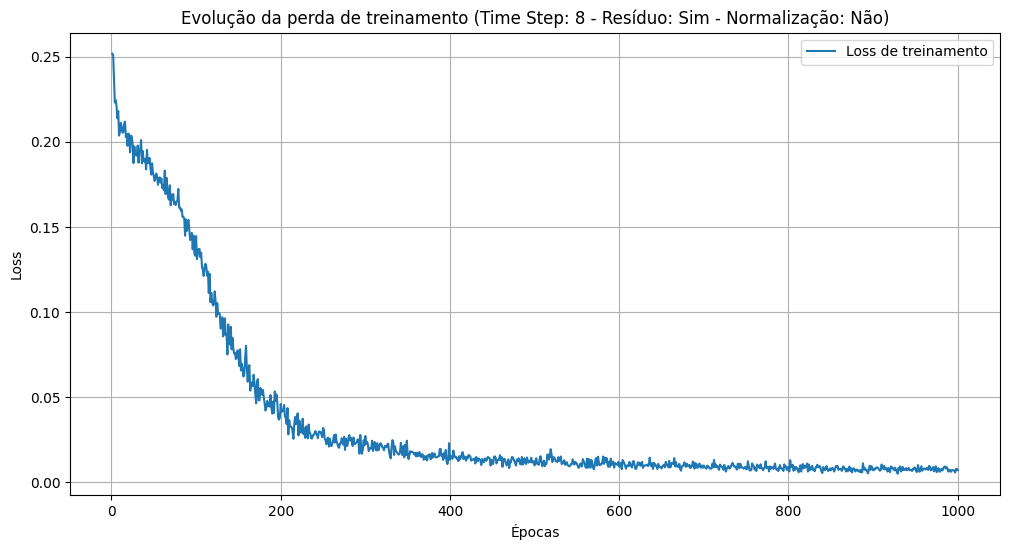

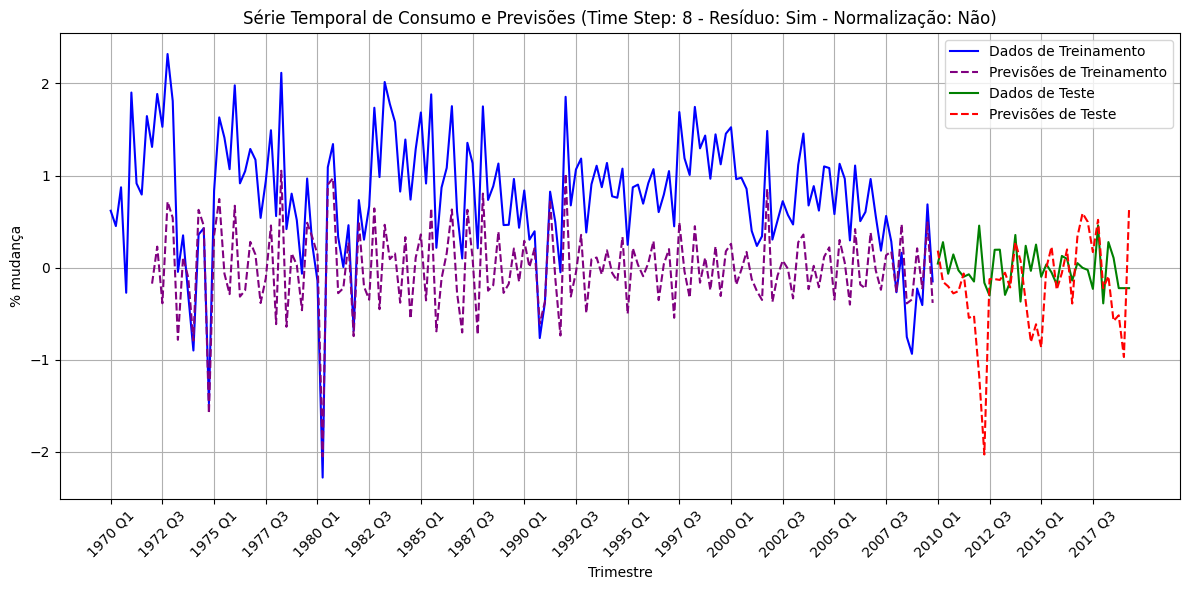

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 8 - Resíduo: Não - Normalização: Sim
Epoch [100/1000], Loss: 0.0270
Epoch [200/1000], Loss: 0.0223
Epoch [300/1000], Loss: 0.0217
Epoch [400/1000], Loss: 0.0121
Epoch [500/1000], Loss: 0.0109
Epoch [600/1000], Loss: 0.0072
Epoch [700/1000], Loss: 0.0087
Epoch [800/1000], Loss: 0.0068
Epoch [900/1000], Loss: 0.0058
Epoch [1000/1000], Loss: 0.0038


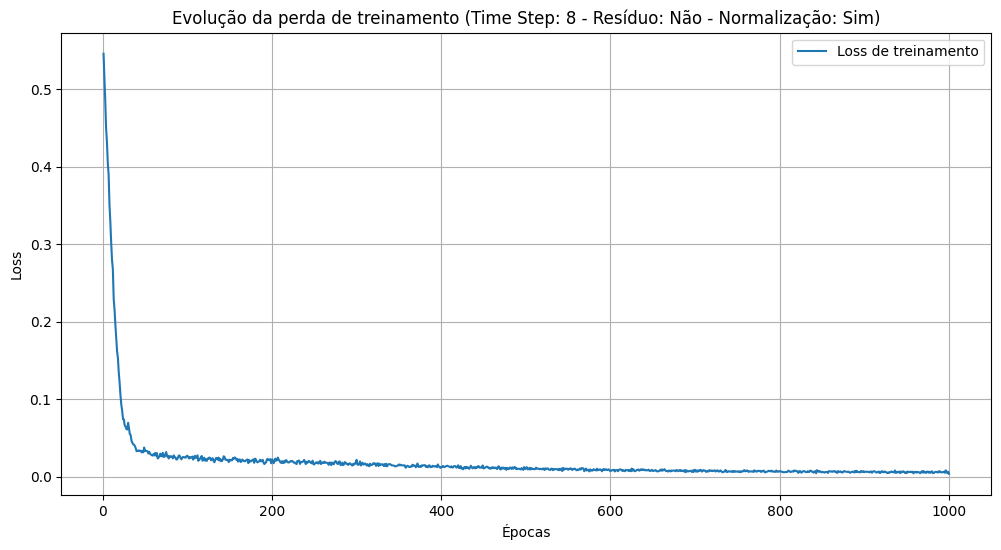

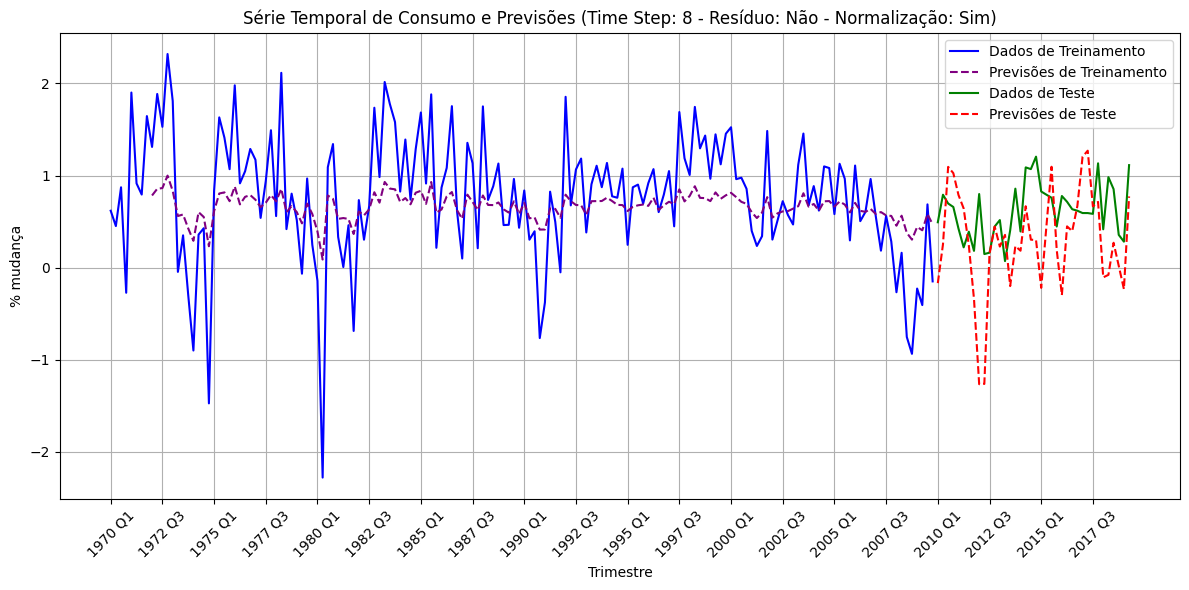

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 8 - Resíduo: Não - Normalização: Não
Epoch [100/1000], Loss: 0.3463
Epoch [200/1000], Loss: 0.1689
Epoch [300/1000], Loss: 0.0883
Epoch [400/1000], Loss: 0.0384
Epoch [500/1000], Loss: 0.0445
Epoch [600/1000], Loss: 0.0290
Epoch [700/1000], Loss: 0.0331
Epoch [800/1000], Loss: 0.0193
Epoch [900/1000], Loss: 0.0184
Epoch [1000/1000], Loss: 0.0172


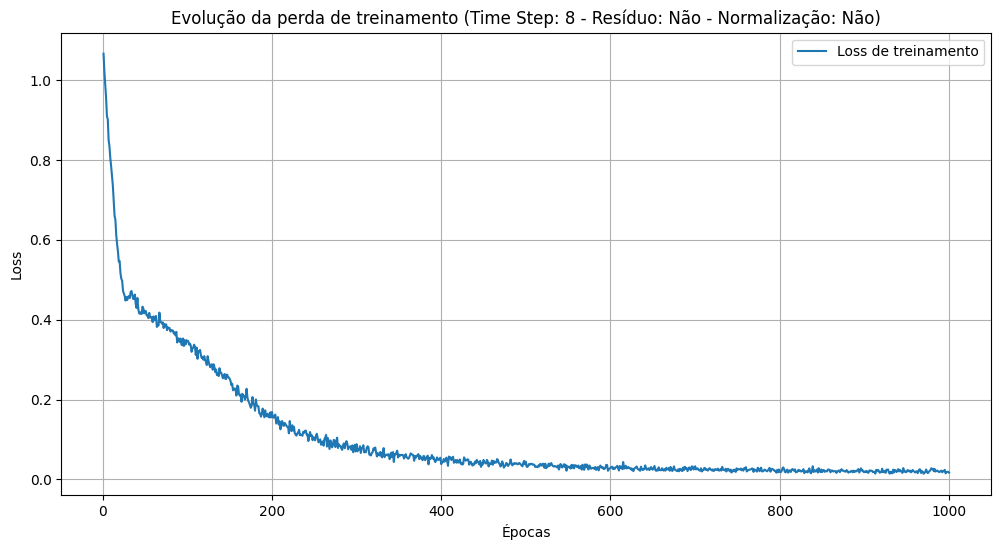

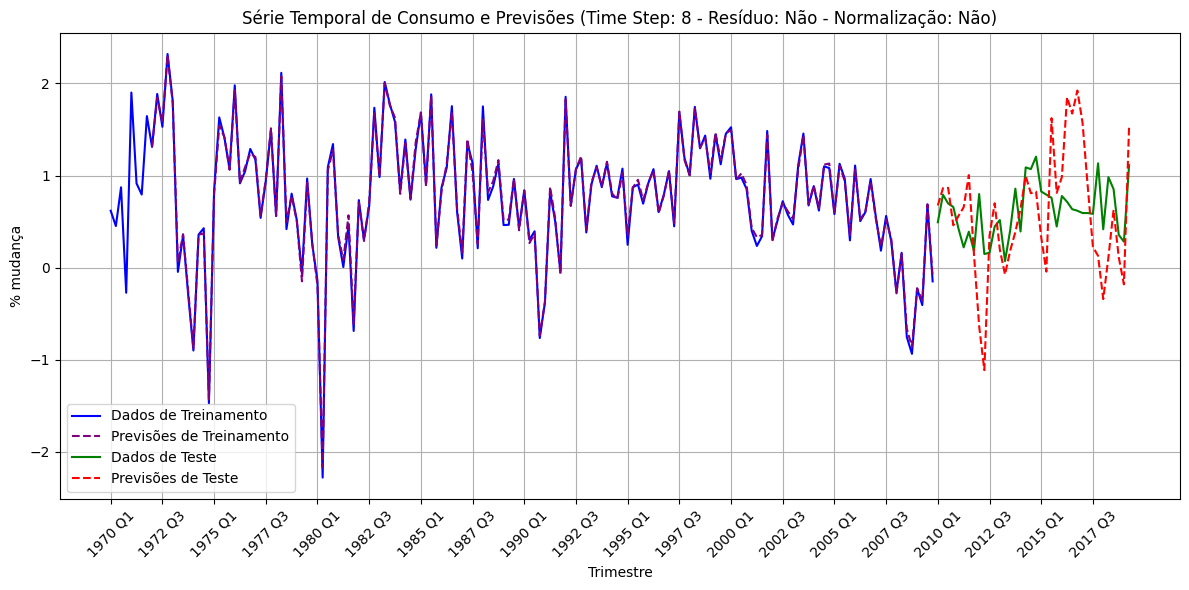

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 12 - Resíduo: Sim - Normalização: Sim
Epoch [100/1000], Loss: 0.0259
Epoch [200/1000], Loss: 0.0231
Epoch [300/1000], Loss: 0.0229
Epoch [400/1000], Loss: 0.0198
Epoch [500/1000], Loss: 0.0165
Epoch [600/1000], Loss: 0.0171
Epoch [700/1000], Loss: 0.0129
Epoch [800/1000], Loss: 0.0104
Epoch [900/1000], Loss: 0.0091
Epoch [1000/1000], Loss: 0.0075


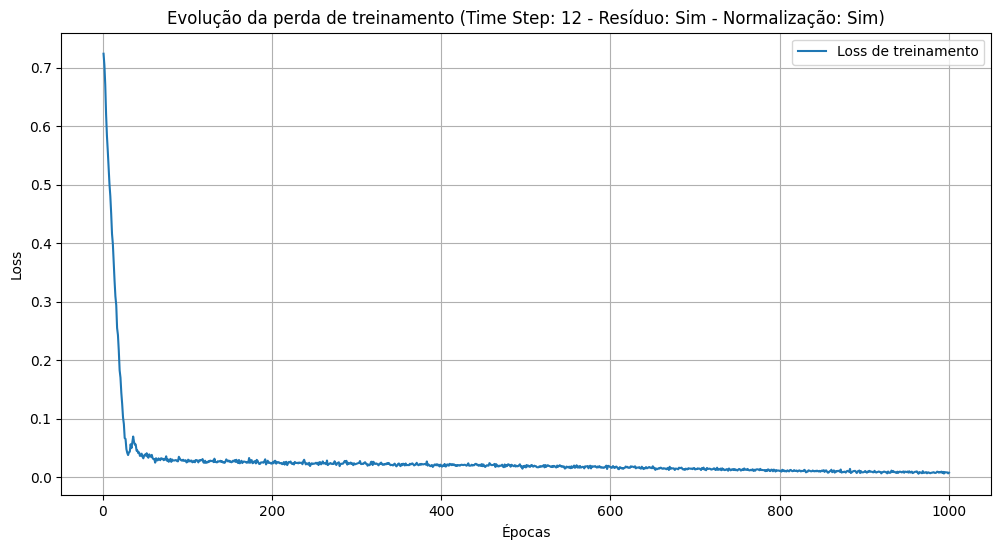

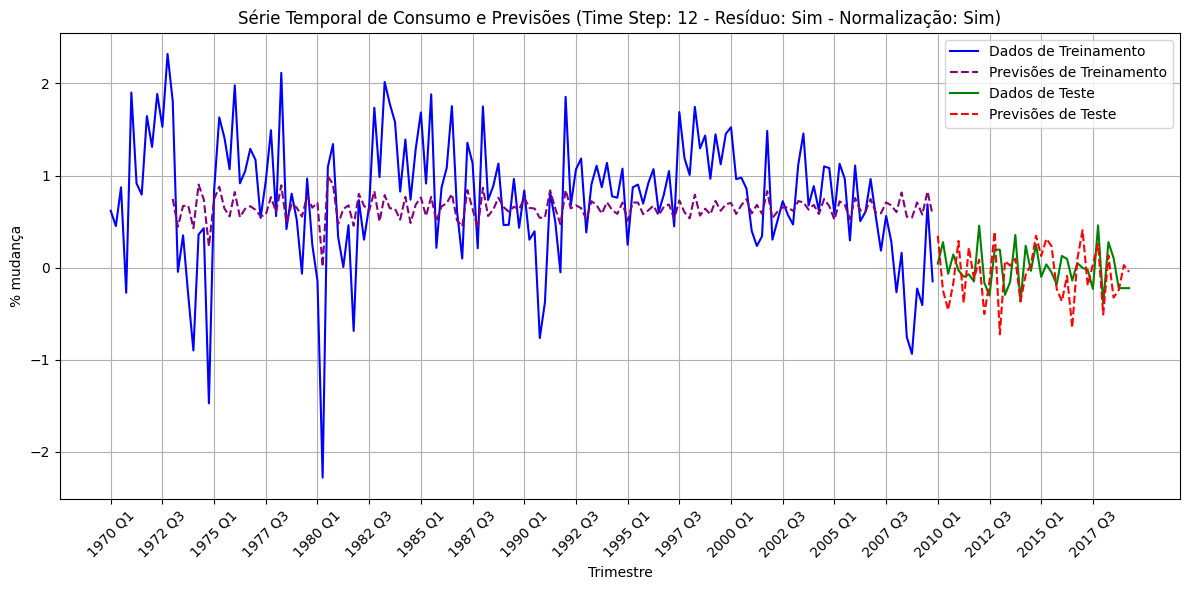

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 12 - Resíduo: Sim - Normalização: Não
Epoch [100/1000], Loss: 0.1415
Epoch [200/1000], Loss: 0.0460
Epoch [300/1000], Loss: 0.0194
Epoch [400/1000], Loss: 0.0164
Epoch [500/1000], Loss: 0.0113
Epoch [600/1000], Loss: 0.0113
Epoch [700/1000], Loss: 0.0100
Epoch [800/1000], Loss: 0.0097
Epoch [900/1000], Loss: 0.0073
Epoch [1000/1000], Loss: 0.0065


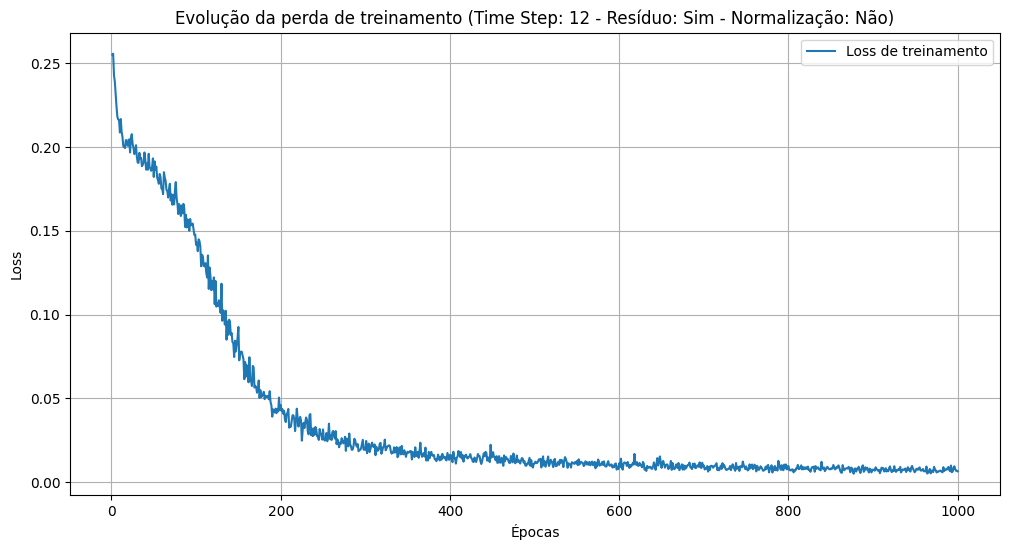

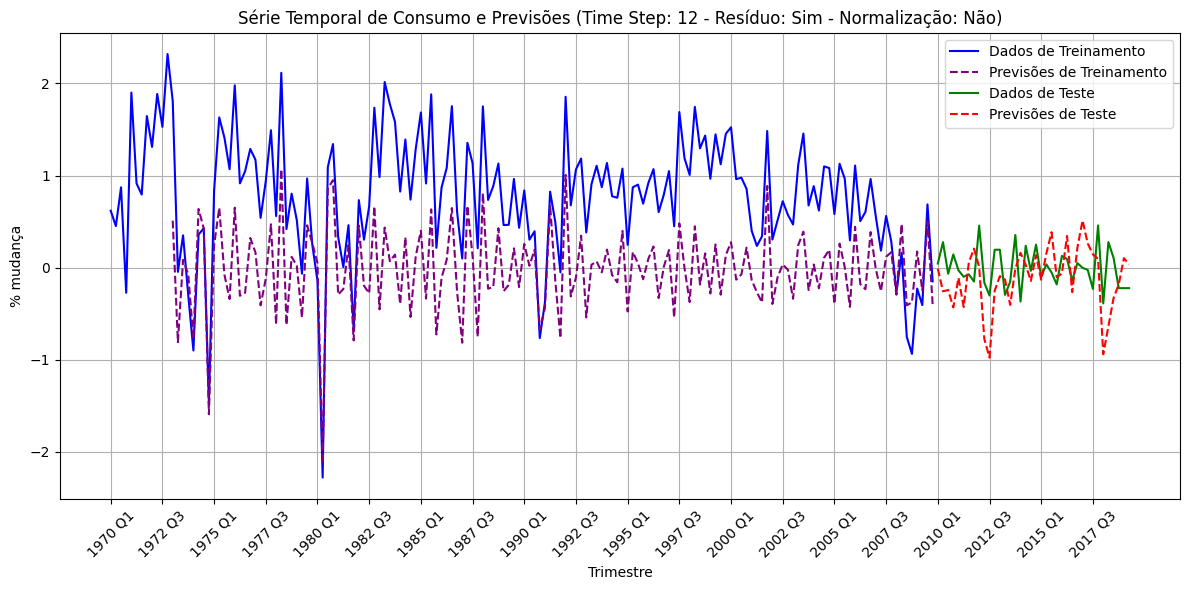

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 12 - Resíduo: Não - Normalização: Sim
Epoch [100/1000], Loss: 0.0208
Epoch [200/1000], Loss: 0.0197
Epoch [300/1000], Loss: 0.0157
Epoch [400/1000], Loss: 0.0097
Epoch [500/1000], Loss: 0.0111
Epoch [600/1000], Loss: 0.0081
Epoch [700/1000], Loss: 0.0072
Epoch [800/1000], Loss: 0.0069
Epoch [900/1000], Loss: 0.0053
Epoch [1000/1000], Loss: 0.0042


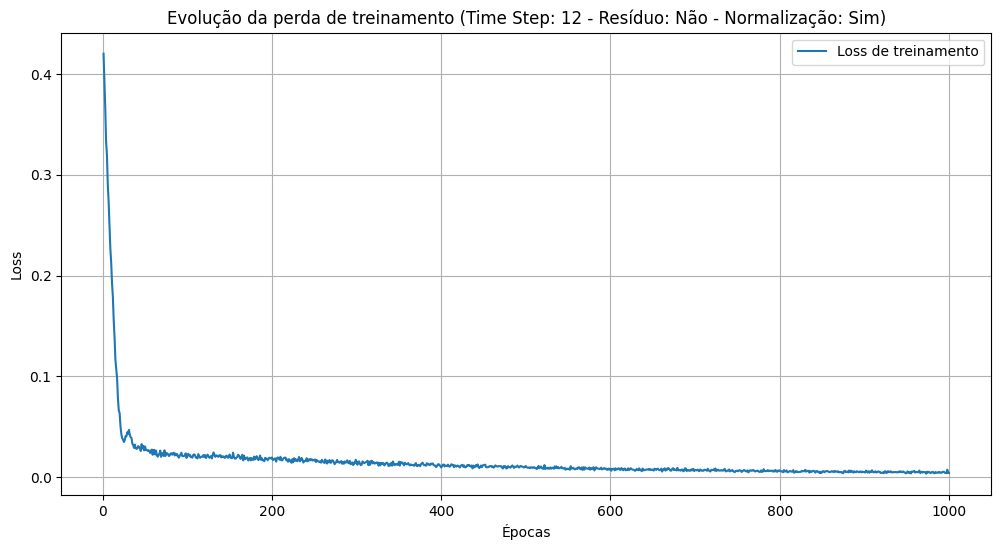

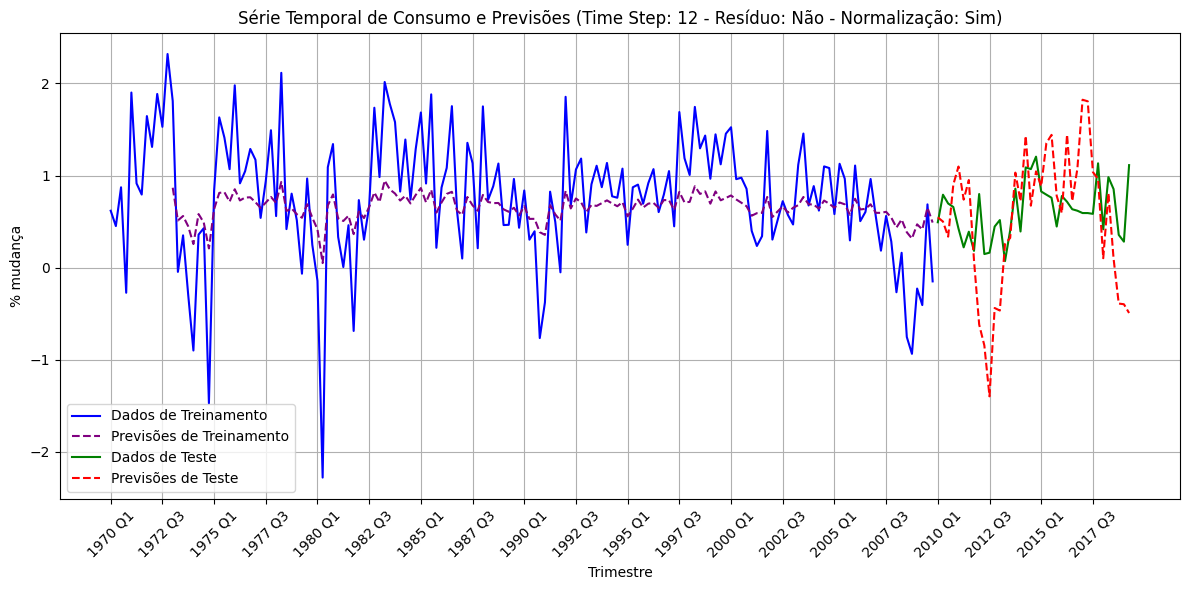

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 12 - Resíduo: Não - Normalização: Não
Epoch [100/1000], Loss: 0.3001
Epoch [200/1000], Loss: 0.1273
Epoch [300/1000], Loss: 0.0775
Epoch [400/1000], Loss: 0.0529
Epoch [500/1000], Loss: 0.0479
Epoch [600/1000], Loss: 0.0328
Epoch [700/1000], Loss: 0.0358
Epoch [800/1000], Loss: 0.0251
Epoch [900/1000], Loss: 0.0208
Epoch [1000/1000], Loss: 0.0246


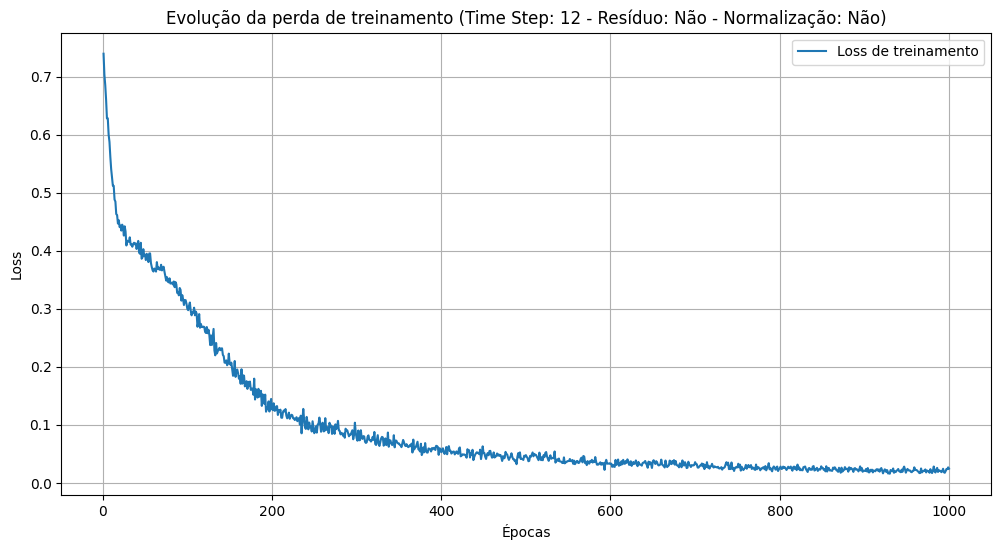

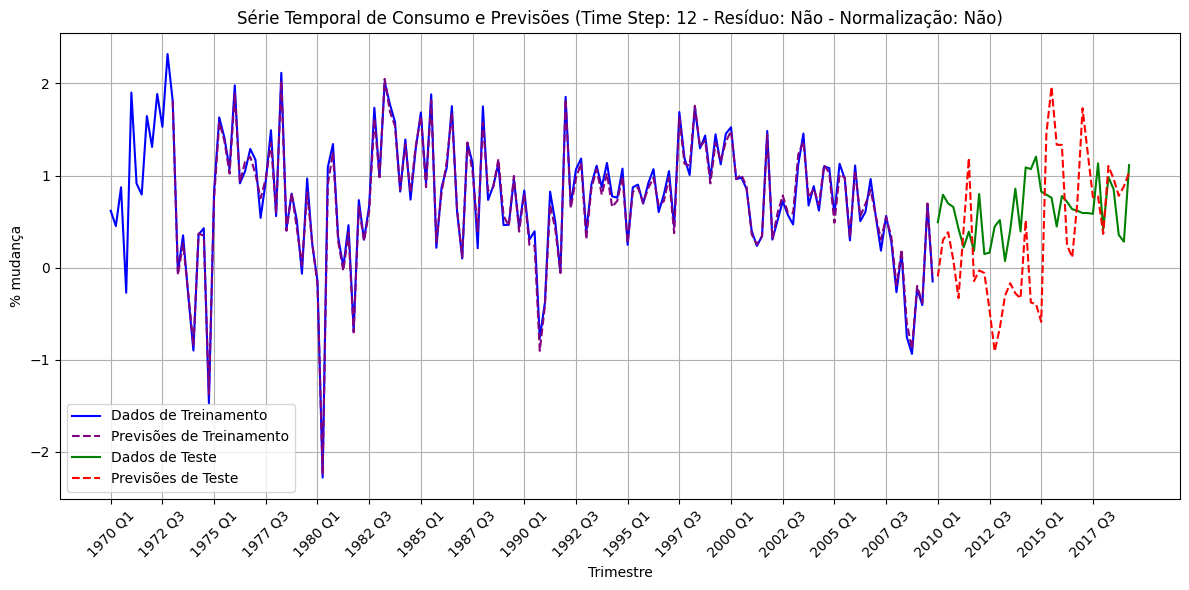

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 30 - Resíduo: Sim - Normalização: Sim
Epoch [100/1000], Loss: 0.0253
Epoch [200/1000], Loss: 0.0242
Epoch [300/1000], Loss: 0.0229
Epoch [400/1000], Loss: 0.0208
Epoch [500/1000], Loss: 0.0172
Epoch [600/1000], Loss: 0.0154
Epoch [700/1000], Loss: 0.0128
Epoch [800/1000], Loss: 0.0122
Epoch [900/1000], Loss: 0.0099
Epoch [1000/1000], Loss: 0.0088


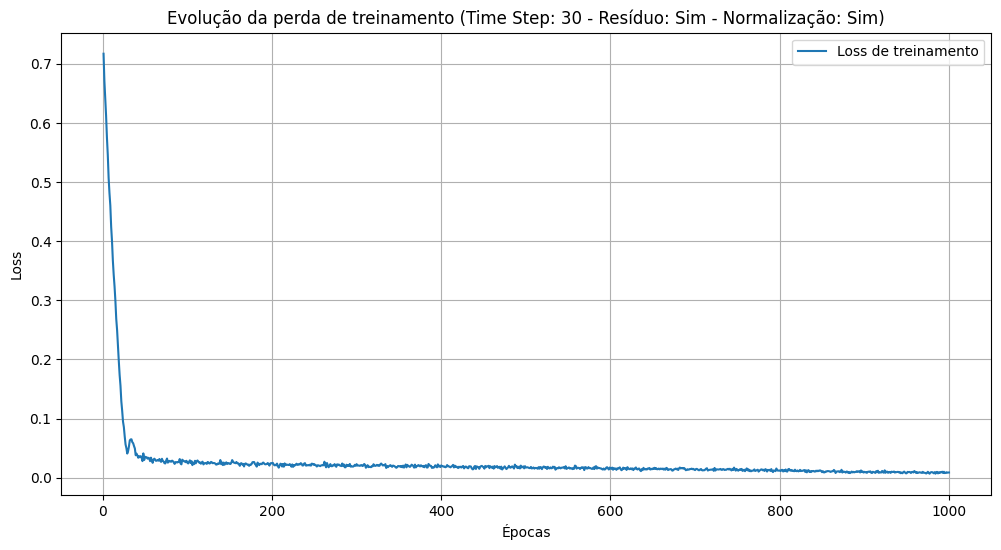

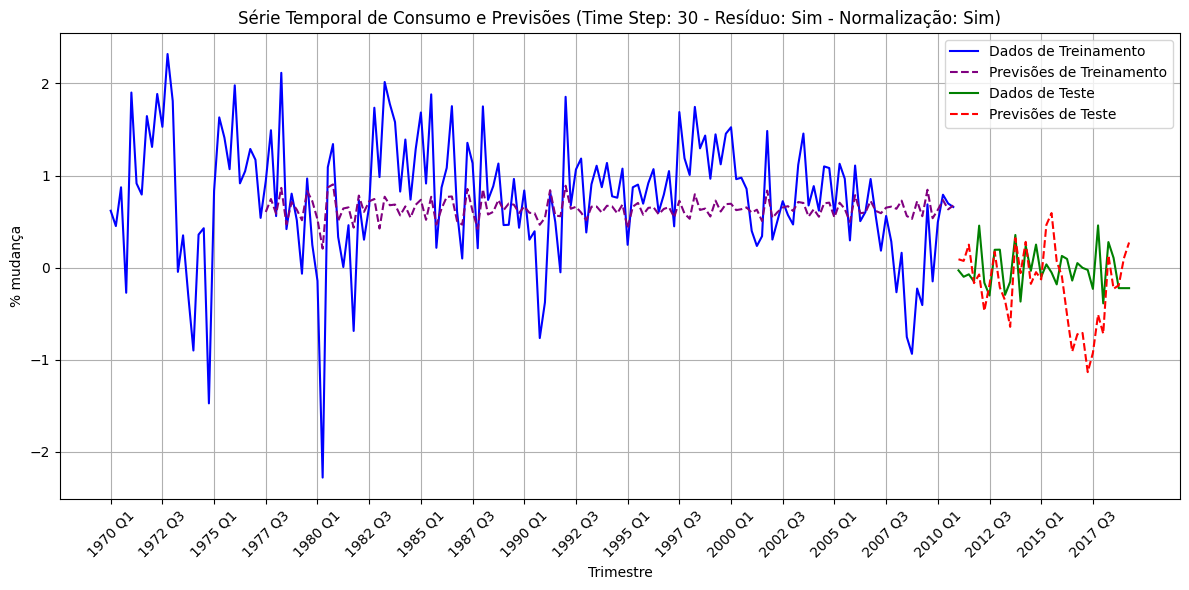

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 30 - Resíduo: Sim - Normalização: Não
Epoch [100/1000], Loss: 0.1160
Epoch [200/1000], Loss: 0.0311
Epoch [300/1000], Loss: 0.0186
Epoch [400/1000], Loss: 0.0117
Epoch [500/1000], Loss: 0.0092
Epoch [600/1000], Loss: 0.0077
Epoch [700/1000], Loss: 0.0065
Epoch [800/1000], Loss: 0.0070
Epoch [900/1000], Loss: 0.0078
Epoch [1000/1000], Loss: 0.0072


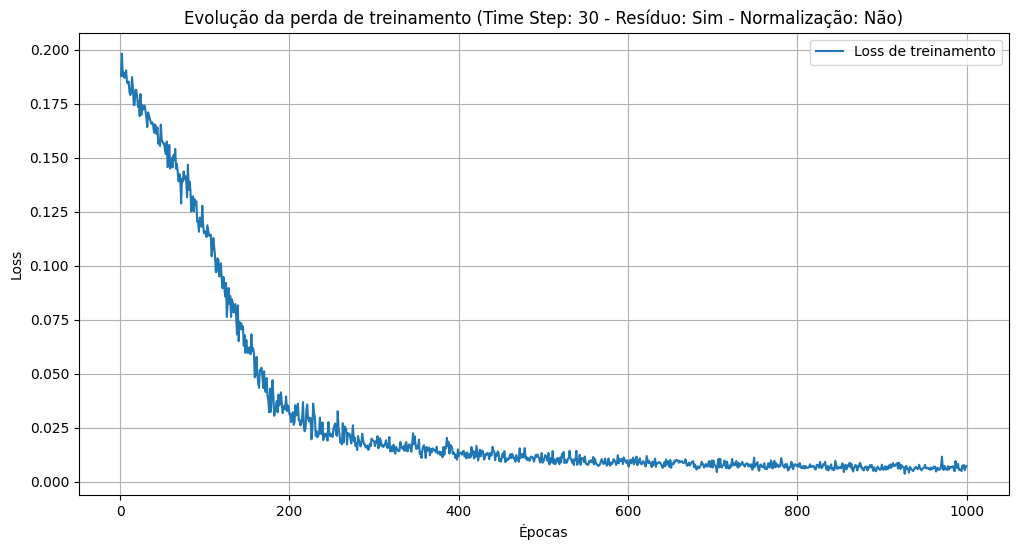

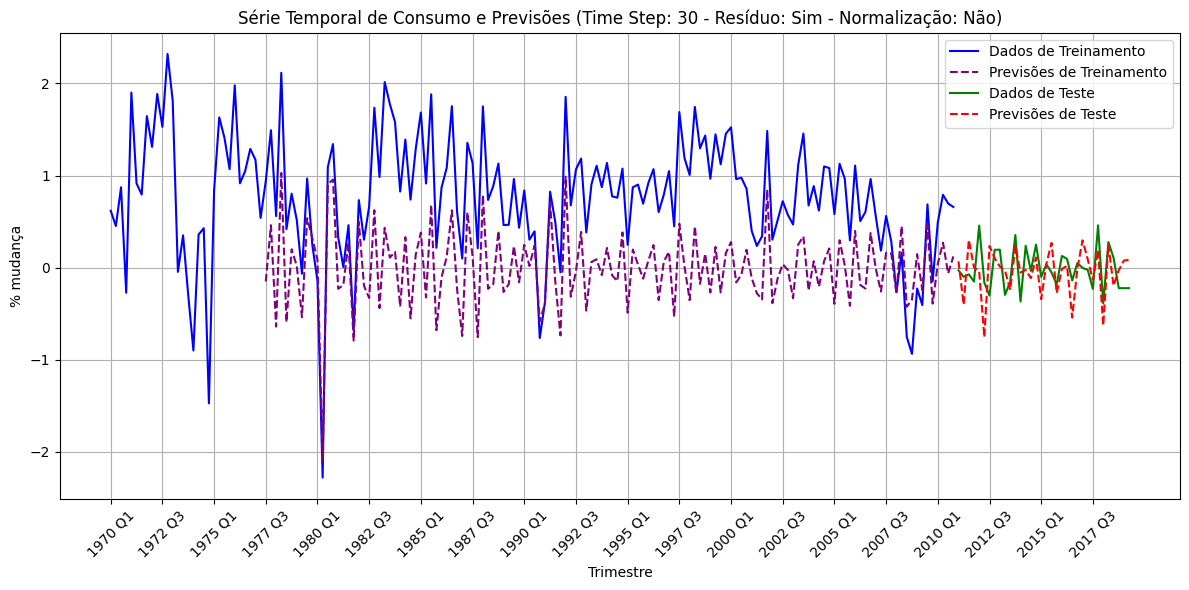

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 30 - Resíduo: Não - Normalização: Sim
Epoch [100/1000], Loss: 0.0176
Epoch [200/1000], Loss: 0.0130
Epoch [300/1000], Loss: 0.0101
Epoch [400/1000], Loss: 0.0093
Epoch [500/1000], Loss: 0.0073
Epoch [600/1000], Loss: 0.0056
Epoch [700/1000], Loss: 0.0054
Epoch [800/1000], Loss: 0.0045
Epoch [900/1000], Loss: 0.0033
Epoch [1000/1000], Loss: 0.0030


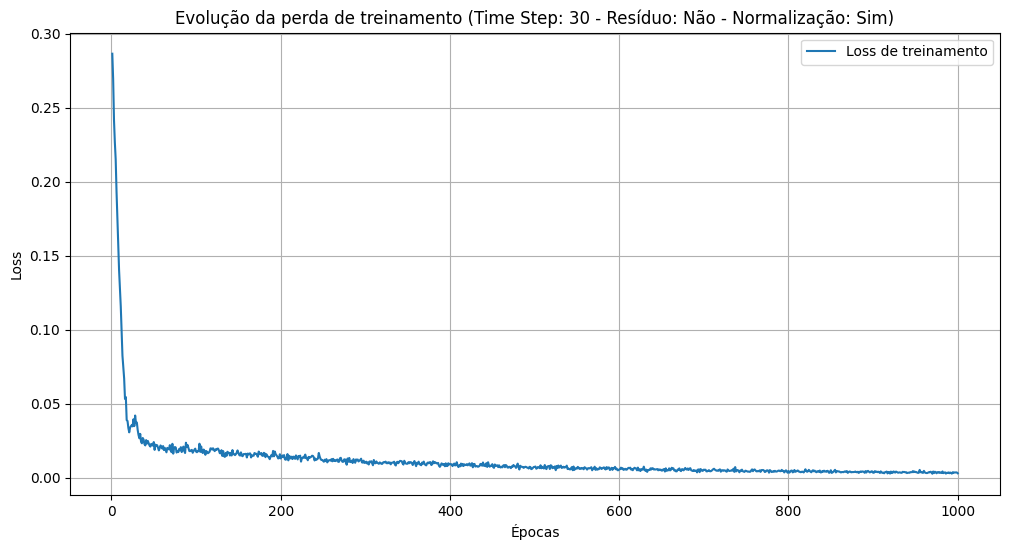

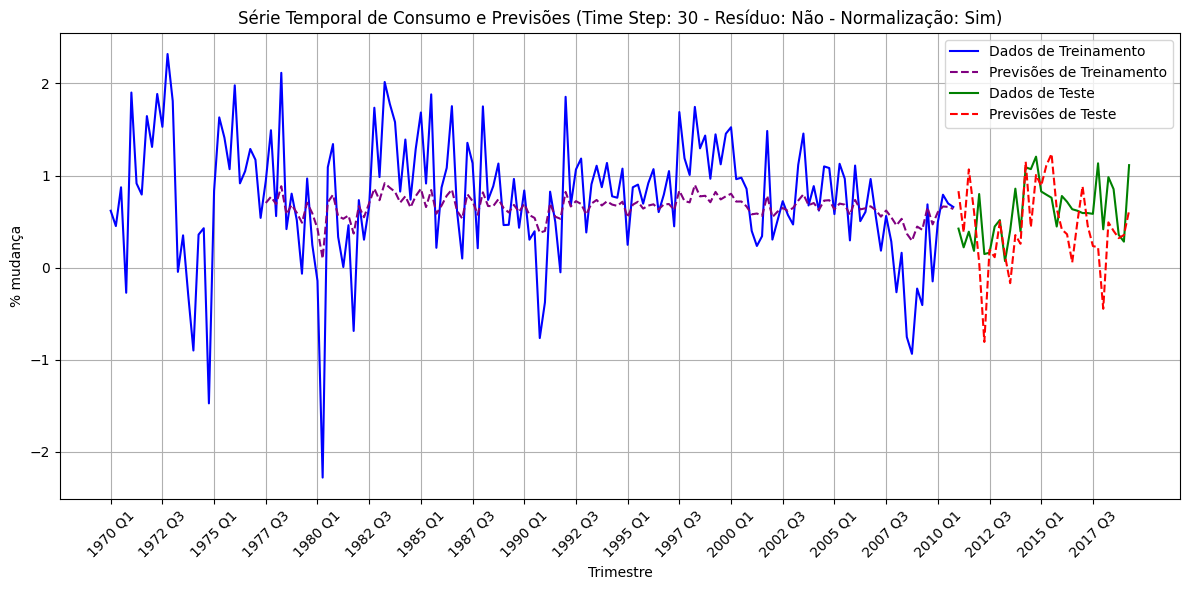

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Cenário: Time Step: 30 - Resíduo: Não - Normalização: Não
Epoch [100/1000], Loss: 0.3142
Epoch [200/1000], Loss: 0.1774
Epoch [300/1000], Loss: 0.0983
Epoch [400/1000], Loss: 0.0540
Epoch [500/1000], Loss: 0.0429
Epoch [600/1000], Loss: 0.0297
Epoch [700/1000], Loss: 0.0285
Epoch [800/1000], Loss: 0.0302
Epoch [900/1000], Loss: 0.0204
Epoch [1000/1000], Loss: 0.0255


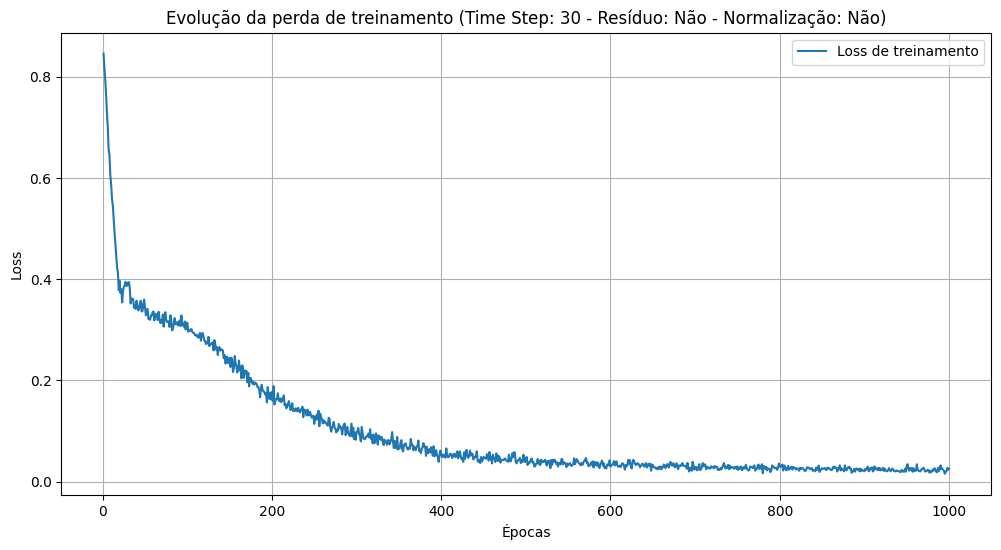

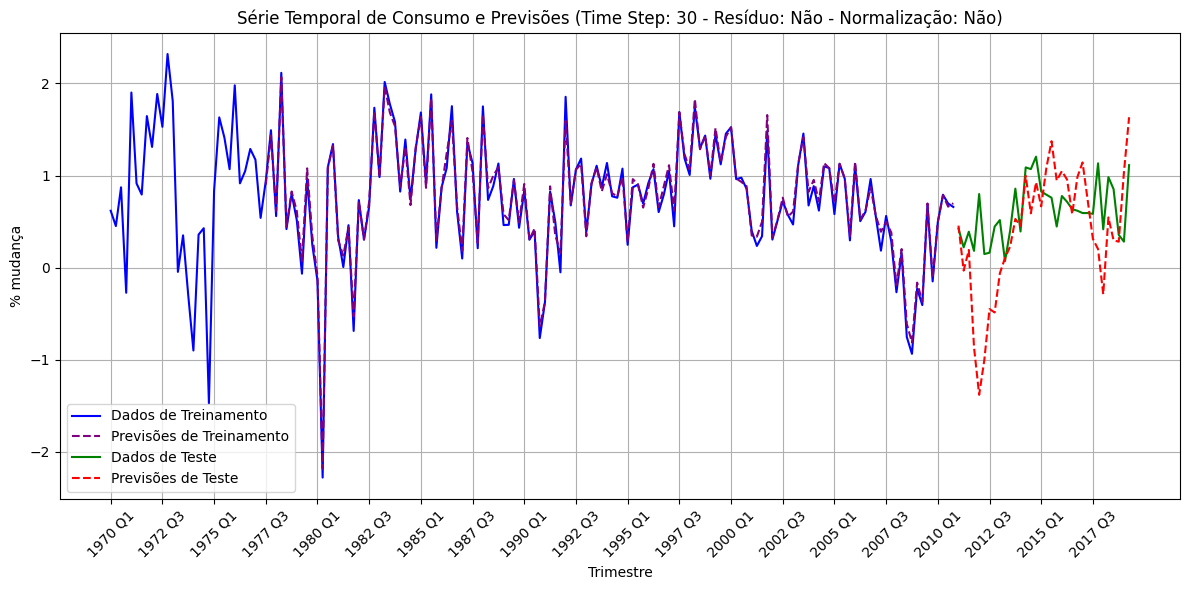

    Time Step  Use Residual Only  Normalize       MSE        R2       MAPE
0           4               True       True  0.135076 -1.726975   6.874301
1           4               True      False  0.162419 -2.278976   7.266285
2           4              False       True  0.453147 -3.568574   1.327884
3           4              False      False  0.429884 -3.334041   1.237610
4           8               True       True  0.342209 -6.299674  29.042683
5           8               True      False  0.337416 -6.197440  14.563052
6           8              False       True  0.430031 -3.959686   1.161527
7           8              False      False  0.396514 -3.573123   1.068955
8          12               True       True  0.098901 -1.109662   9.907974
9          12               True      False  0.138630 -1.957117  11.693921
10         12              False       True  0.477771 -4.510278   1.346591
11         12              False      False  0.576777 -5.652142   1.318680
12         30            

In [35]:
# 5. Função Principal para Testar Diferentes Cenários
def test_scenarios(df, time_steps, use_residual_options, normalize_options):
    results = []
    for time_step in time_steps:
        for use_residual_only in use_residual_options:
            for normalize in normalize_options:
                df_copy = df.copy()
                
                # Decomposição
                df_copy = decompose_series(df_copy, use_residual_only=use_residual_only)

                # Normalização
                if normalize:
                    df_copy, scaler_consumption, scaler_features = normalize_data(df_copy)

                # Criando X e y
                data = df_copy[['Consumption', 'Income', 'Production', 'Savings', 'Unemployment']].values
                X, y = create_dataset(data, time_step)

                # Verificando e lidando com NaN no conjunto
                if np.isnan(X).any() or np.isnan(y).any():
                    print("Encontrados NaNs em X ou y. Substituindo por zeros.")
                    X = np.nan_to_num(X)
                    y = np.nan_to_num(y)

                # Dividindo em treino e teste
                train_size = int(len(X) * 0.8)
                X_train, X_test = X[:train_size], X[train_size:]
                y_train, y_test = y[:train_size], y[train_size:]

                # Criando e treinando o modelo
                model = LSTMModel(input_size=X_train.shape[2], hidden_layer_size=50, output_size=1)
                criterion = torch.nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

                # Construção do nome do cenário
                scenario = f"Time Step: {time_step} - Resíduo: {'Sim' if use_residual_only else 'Não'} - Normalização: {'Sim' if normalize else 'Não'}"
                print("~"*60, "\n", f"Cenário: {scenario}")

                mse, r2, mape = train_and_evaluate_model(X_train, y_train, X_test, y_test, model, criterion, optimizer, 
                                                         1000, 100, normalize, scaler_consumption, df, time_step, scenario)
                    
                # Armazenando resultados
                results.append({
                    'Time Step': time_step,
                    'Use Residual Only': use_residual_only,
                    'Normalize': normalize,
                    'MSE': mse,
                    'R2': r2,
                    'MAPE': mape
                })
    return pd.DataFrame(results)

# Exemplo de uso
time_steps = [4, 8, 12, 30]                 # Testar diferentes tamanhos de janela
use_residual_options = [True, False]        # Usar apenas resíduo ou não
normalize_options = [True, False]           # Testar com e sem normalização

# Executa o pipeline
results = test_scenarios(df, time_steps, use_residual_options, normalize_options)

# Visualizando os resultados
print(results)